In [25]:
import pandas as pd
import random

In [2]:
df = pd.read_csv("stocks.csv")

In [9]:
df = df.iloc[:,1:]

In [10]:
returns = df.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 1500000
risk_free_rate = 0.0178

Getting weights with given, fixed, portfolio standard deviations $\sigma_p$. Indeed, one can fix a grid of volatilities $σ_{p_1},...σ_{p_n}$, then for each $σ_{p_i}$, maximize expected returns with the constraint that the volatility is no larger than $σ_{p_i}$, to get $μ_{p_i}$. Then $(σ_{p_i},μ_{p_i})$ are $n$ points on the efficient frontier. 

$$\begin{cases}
\begin{align}
\max returns &= \alpha + \beta_1 stock_1 + \beta_2 stock_2 + ... + \varepsilon\\
&\varepsilon = \sqrt{\beta^2\Sigma^2+2\beta Cov\beta^T} - \sigma_p\\
&\forall i, \beta_i \geq 0
\end{align}
\end{cases}$$

We start with $\sigma_p= 0.2$ 

We will chose $\beta$ to minimize the sum of squared errors. Finding an exact solution is not easy to do by hand, which means we'll need to use graduent descent. We'll start by creating an error function to minimize. For each stochastic graduent descent we'll just want the squared error corresponding to a single prediction.

In [17]:
def error(x_i, sigma_p, beta):
    return sigma_p - predict(beta)

In [16]:
def squarred_error(x_i, sigma_p, beta):
    return error(x_i,sigma_p, beta)**2

In [19]:
def squared_error_gradient(x_i, sigma_p, beta):
    """the gradient (with respect to beta)
    corresponding to the ith squared error term"""
    return [-2*x_ij * error(x_i, sigma_p, beta)
           for x_ij in x_i]

At this point we are ready to find the optimal beta using stochastic gradient decent:

In [21]:
def estimate_beta(x,y):
    beta_initial = [random.random() for x_i in x[0]]
    return minimize_stochastic(squared_error,
                              squared_error_gradient,
                              x,y,
                              beta_initial,
                              0.001)

In [26]:
random.seed(0)
x = returns
beta = estimate_beta(x, daily_minutes_good)

NameError: name 'daily_minutes_good' is not defined

The following code generates points directly on the Pareto frontier. It uses the fact that the minimizer of a quadratic objective under linear constraints can be obtained by solving a linear system. The frontier changes shape if you uncomment the lines that add the risk-free asset.

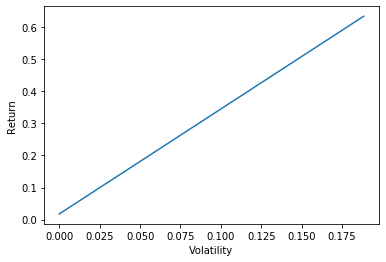

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read data
stock_prices = pd.read_csv('stocks.csv', index_col=0)
returns = stock_prices.pct_change()
mu = 252 * returns.mean().values
sigma = 252 * returns.cov().values
n = mu.shape[0]

# add risk free asset to mu/sigma
risk_free_rate = 0.0178
z = np.zeros((n,1))
# mu = np.block([mu, risk_free_rate])
# sigma = np.block([[sigma, z], [z.T, 0]])
# n = mu.shape[0]

# solve minimize w'∑w subject to μ'w = r, e'w=1 for varying r
mu = np.expand_dims(mu, axis=1)
e = np.ones((n,1))
returns = np.linspace(risk_free_rate, np.max(mu))
volatilities = []
for r in returns:
    A = np.block([[2*sigma, mu, e], [mu.T, 0, 0], [e.T, 0, 0]])
    b = np.zeros(n+2)
    b[n] = r
    b[n+1] = 1
    w = np.linalg.solve(A, b)[:n]

    volatility = np.sqrt( w.T @ sigma @ w )
    volatilities.append(volatility)

# plot results
plt.plot(volatilities, returns)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [79]:
results

array([[0.12808235, 0.12806968, 0.12817238, 0.12839017, 0.12872246,
        0.12916837, 0.12972672, 0.13039608, 0.13117474, 0.13206078,
        0.13305204, 0.13414619, 0.13534074, 0.13663305, 0.13802038,
        0.1394999 , 0.14106869, 0.14272383, 0.14446233, 0.14628124,
        0.14817758, 0.15014843, 0.15219089, 0.15430211, 0.15647931,
        0.15871978, 0.16102088, 0.16338004, 0.16579479, 0.16826274,
        0.17078156, 0.17334906, 0.1759631 , 0.17862163, 0.18132269,
        0.18406443, 0.18684504, 0.18966281, 0.19251612, 0.1954034 ,
        0.19832318, 0.20127404, 0.20425462, 0.20726366, 0.21029992,
        0.21336226, 0.21644954, 0.21956074, 0.22269484, 0.22585089],
       [0.0178    , 0.03035624, 0.04291247, 0.05546871, 0.06802495,
        0.08058118, 0.09313742, 0.10569365, 0.11824989, 0.13080613,
        0.14336236, 0.1559186 , 0.16847484, 0.18103107, 0.19358731,
        0.20614355, 0.21869978, 0.23125602, 0.24381225, 0.25636849,
        0.26892473, 0.28148096, 0.2940372 , 0.3

In [83]:
def efficient_portfolios(returns, risk_free_rate, sigma, mu, e):
    weights_record = []
    volatilities = []
    results = np.zeros((3,len(returns)))
    i = 0
    for portfolio_return in returns:
        A = np.block([[2*sigma, mu, e], [mu.T, 0, 0], [e.T, 0, 0]])
        b = np.zeros(n+2)
        b[n] = portfolio_return
        b[n+1] = 1
        w = np.linalg.solve(A, b)[:n]
        weights_record.append(w)
        portfolio_std_dev = np.sqrt( w.T @ sigma @ w )
        volatilities.append(portfolio_std_dev)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
        i+=1
    return results, weights_record, volatilities

def display_simulated_ef_with_random(mean_returns, risk_free_rate, sigma, mu, e, df):
    results, weights, volatilities = efficient_portfolios(mean_returns,risk_free_rate, sigma, mu, e)
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    
    return max_sharpe_allocation, min_vol_allocation

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.63
Annualised Volatility: 0.23


               DD  ADBE  ATVI   APD    NVS      A   ADI    AVB    AYI   AAN  \
allocation -19.33  0.03 -0.32  29.3  12.65 -14.57  2.85 -25.28 -13.17  2.77   

            ...   SWKS    NOV  KMT   MDT   RIO   PSA   STE  POWI  VALE   TX  
allocation  ... -15.61 -10.08 -7.2 -3.16  7.57 -9.39  7.93  5.13  1.07  8.4  

[1 rows x 51 columns]
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.03
Annualised Volatility: 0.13


             DD  ADBE  ATVI   APD   NVS     A   ADI   AVB   AYI   AAN  ...  \
allocation -0.6 -7.11  5.36  3.81  22.9 -3.69  7.37 -1.27 -1.13 -0.16  ...   

            SWKS   NOV   KMT   MDT   RIO    PSA   STE  POWI  VALE    TX  
allocation  -6.4 -0.25 -9.24  6.15  4.41  19.86 -1.31 -0.23 -2.99  6.05  

[1

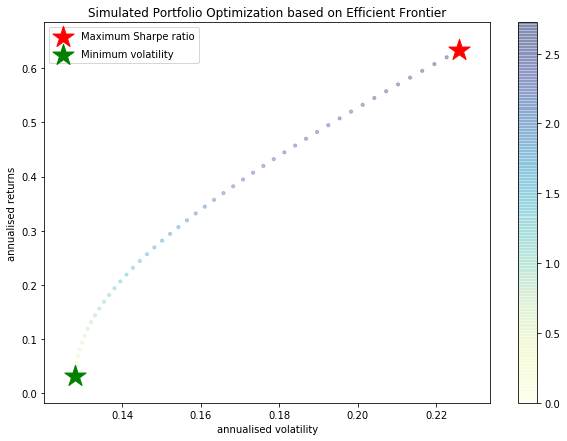

In [84]:
# returns = df.pct_change()
# mean_returns = returns.mean()
# cov_matrix = returns.cov()
# num_portfolios = 25000
# risk_free_rate = 0.0178


stock_prices = pd.read_csv('stocks.csv', index_col=0)
returns = stock_prices.pct_change()
mu = 252 * returns.mean().values
sigma = 252 * returns.cov().values
n = mu.shape[0]

# add risk free asset to mu/sigma
risk_free_rate = 0.0178
z = np.zeros((n,1))
#mu = np.block([mu, risk_free_rate])
#sigma = np.block([[sigma, z], [z.T, 0]])
#n = mu.shape[0]

# solve minimize w'∑w subject to μ'w = r, e'w=1 for varying r
mu = np.expand_dims(mu, axis=1)
e = np.ones((n,1))
returns = np.linspace(risk_free_rate, np.max(mu))


max_sharpe_al, min_vol_al = display_simulated_ef_with_random(returns, risk_free_rate, sigma, mu, e, stock_prices)